<a href="https://colab.research.google.com/github/seismosmsr/hawaii_soils/blob/main/soil_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

def preprocess_and_train_model(matched_data):
    # Data Preprocessing Steps
    # matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
    # matched_data = matched_data.reset_index(drop=True)
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
    numeric_cols = matched_data.iloc[:,keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    scaler = MinMaxScaler()
    scaler.fit(numeric_cols)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

    # Model Definition
    def build_model(input_shape):
        model = Sequential([
            Dense(256, activation='relu', input_dim=input_shape),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(512, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1, activation='linear')  # Adjust output layer according to your needs
        ])
        return model

    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = build_model(X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=300, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)

    # Predictions and Evaluation
    predictions = model.predict(X_test).flatten()
    dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y_test
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    r_squared = r2_score(inversed_truth, inversed_predictions)

    return model, test_loss, r_squared, inversed_predictions, scaler

# Use the function with your DataFrame
# model, test_loss, r_squared, predictions = preprocess_and_train_model(your_dataframe)


In [5]:
def predict_on_reserve(matched_data,model,scaler):
    # Data Preprocessing Steps
    # matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
    # matched_data = matched_data.reset_index(drop=True)
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
    numeric_cols = matched_data.iloc[:,keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]

    # Predictions and Evaluation
    predictions = model.predict(X).flatten()
    dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    matched_data['inversed_predictions'] = inversed_predictions.flatten()
    matched_data['inversed_imp_c'] =inversed_truth.flatten()
    return matched_data

In [6]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [7]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [8]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [9]:
from shapely.geometry import Point

soils_csv = soils_csv[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'] )), axis=1)
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")

In [10]:


# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [11]:
# Apply a buffer to each geometry in one of the GeoDataFrames (e.g., soils_gpd)
soils_buffered = soils_gpd.copy()

soils_buffered.geometry = soils_buffered.to_crs(epsg=32604).geometry.buffer(1000).to_crs('ESRI:102261')

# soils_gpd = soils_gpd
# Step 2: Spatial Join
# Perform a spatial join with the buffered GeoDataFrame
# This finds all drivers_gpd points that fall within the 10,000-meter buffer of any point in soils_gpd
matches_within_distance = gpd.sjoin(soils_buffered, drivers_gpd, how='left', op='intersects')


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [12]:
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)


In [16]:
# Use the function with your DataFrame
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)


prediction_list = []

for i in range(10):
  matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
  matched_data = matched_data.reset_index(drop=True)
  model, test_loss, r_squared, inversed_predictions, scaler = preprocess_and_train_model(matched_data)

  predictions = predict_on_reserve(reserve_data,model,scaler)
  prediction_list.append(predictions)


<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 78ms/step - loss: 3.1367 - val_loss: 0.1745
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 2.5006 - val_loss: 0.0754
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 2.4310 - val_loss: 0.0474
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 2.4311 - val_loss: 0.0326
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 1.7755 - val_loss: 0.0397
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 2.1377 - val_loss: 0.0392
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 1.3427 - val_loss: 0.0419
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 1.4417 - val_loss: 0.0405
Epoch 9/100
5/5 [==============================] - 0s 18ms/step - loss: 1.3641 - val_loss: 0.0416
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 1.2172 - val_loss: 0.0397
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 66ms/step - loss: 2.3203 - val_loss: 0.0239
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 2.7192 - val_loss: 0.0703
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 2.2574 - val_loss: 0.0222
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 2.7572 - val_loss: 0.0229
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 1.6249 - val_loss: 0.0300
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 1.8889 - val_loss: 0.0354
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 1.4342 - val_loss: 0.0353
Epoch 8/100
5/5 [==============================] - 0s 18ms/step - loss: 1.4632 - val_loss: 0.0358
Epoch 9/100
5/5 [==============================] - 0s 17ms/step - loss: 1.0934 - val_loss: 0.0372
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 1.2005 - val_loss: 0.0367
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 67ms/step - loss: 3.0539 - val_loss: 0.0443
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 1.8237 - val_loss: 0.0198
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 2.2490 - val_loss: 0.0338
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 2.1088 - val_loss: 0.0306
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 1.5849 - val_loss: 0.0286
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 1.6922 - val_loss: 0.0271
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 1.6479 - val_loss: 0.0289
Epoch 8/100
5/5 [==============================] - 0s 18ms/step - loss: 1.4607 - val_loss: 0.0288
Epoch 9/100
5/5 [==============================] - 0s 18ms/step - loss: 1.3475 - val_loss: 0.0273
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 1.0179 - val_loss: 0.0285
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 65ms/step - loss: 2.4352 - val_loss: 0.0475
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 2.6588 - val_loss: 0.0728
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 2.2562 - val_loss: 0.0400
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 2.4115 - val_loss: 0.0477
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 2.1668 - val_loss: 0.0460
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 1.7629 - val_loss: 0.0472
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 1.7962 - val_loss: 0.0504
Epoch 8/100
5/5 [==============================] - 0s 18ms/step - loss: 1.7539 - val_loss: 0.0430
Epoch 9/100
5/5 [==============================] - 0s 17ms/step - loss: 1.4258 - val_loss: 0.0474
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 1.4466 - val_loss: 0.0457
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 71ms/step - loss: 2.3831 - val_loss: 0.0288
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 2.6930 - val_loss: 0.0234
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 2.1713 - val_loss: 0.0235
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 1.7415 - val_loss: 0.0258
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 1.6315 - val_loss: 0.0297
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 2.0570 - val_loss: 0.0306
Epoch 7/100
5/5 [==============================] - 0s 22ms/step - loss: 1.5922 - val_loss: 0.0294
Epoch 8/100
5/5 [==============================] - 0s 18ms/step - loss: 1.4701 - val_loss: 0.0338
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 1.3896 - val_loss: 0.0320
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 1.4856 - val_loss: 0.0333
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 65ms/step - loss: 2.4624 - val_loss: 0.0180
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 2.3268 - val_loss: 0.0190
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 2.2316 - val_loss: 0.0241
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 1.6761 - val_loss: 0.0241
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 1.7820 - val_loss: 0.0250
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 1.4414 - val_loss: 0.0247
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 1.4681 - val_loss: 0.0290
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 1.6956 - val_loss: 0.0279
Epoch 9/100
5/5 [==============================] - 0s 17ms/step - loss: 1.2708 - val_loss: 0.0270
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 1.2406 - val_loss: 0.0282
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 3s 64ms/step - loss: 2.5915 - val_loss: 0.0784
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 2.6188 - val_loss: 0.0828
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 2.0939 - val_loss: 0.0744
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 1.5625 - val_loss: 0.0514
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 1.6273 - val_loss: 0.0531
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 1.5053 - val_loss: 0.0511
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 1.6082 - val_loss: 0.0439
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 1.2732 - val_loss: 0.0444
Epoch 9/100
5/5 [==============================] - 0s 18ms/step - loss: 1.3687 - val_loss: 0.0437
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 1.6036 - val_loss: 0.0454
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 66ms/step - loss: 3.3606 - val_loss: 0.0334
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 2.8991 - val_loss: 0.0248
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 3.4784 - val_loss: 0.0542
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 2.5707 - val_loss: 0.0336
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 2.0402 - val_loss: 0.0203
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 1.8527 - val_loss: 0.0282
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 1.3885 - val_loss: 0.0333
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 1.5860 - val_loss: 0.0288
Epoch 9/100
5/5 [==============================] - 0s 18ms/step - loss: 1.2727 - val_loss: 0.0312
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 1.3698 - val_loss: 0.0295
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 65ms/step - loss: 2.3529 - val_loss: 0.0330
Epoch 2/100
5/5 [==============================] - 0s 20ms/step - loss: 2.7543 - val_loss: 0.0275
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 2.3172 - val_loss: 0.0303
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 1.8755 - val_loss: 0.0266
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 1.8968 - val_loss: 0.0346
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 1.9404 - val_loss: 0.0333
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 1.4876 - val_loss: 0.0315
Epoch 8/100
5/5 [==============================] - 0s 19ms/step - loss: 1.3914 - val_loss: 0.0341
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 1.3766 - val_loss: 0.0329
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 1.0627 - val_loss: 0.0360
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-4-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 65ms/step - loss: 1.9860 - val_loss: 0.0228
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 2.7208 - val_loss: 0.0436
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 2.9968 - val_loss: 0.0227
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 1.7046 - val_loss: 0.0243
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 1.6686 - val_loss: 0.0290
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 1.4287 - val_loss: 0.0335
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 1.6390 - val_loss: 0.0292
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 1.7802 - val_loss: 0.0295
Epoch 9/100
5/5 [==============================] - 0s 18ms/step - loss: 1.2153 - val_loss: 0.0294
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 1.1370 - val_loss: 0.0262
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [17]:
combined_array = np.array([predictions['inversed_predictions'].values for predictions in prediction_list])

In [45]:
combined_array[combined_array < 0 ] = 0

In [47]:
arr_min = np.min(combined_array.flatten())
arr_max = np.max(combined_array.flatten())

In [59]:
dist_array

array([[ 2.37574004,  2.63710475,  2.84707116, ...,  4.20205896,
         4.4072997 ,  4.50056836],
       [ 2.24507464,  2.94137655,  3.14266126, ...,  5.40542065,
         5.93130787, 14.25299337],
       [ 2.41473759,  2.42849283,  3.17243988, ...,  8.04350113,
         8.57005817,  9.60762931],
       ...,
       [ 1.2193333 ,  1.51536433,  2.06948432, ...,  3.4705317 ,
         3.53626169,  3.75698822],
       [ 1.37579281,  1.39763966,  1.954957  , ...,  3.00215322,
         3.00530665,  3.03257785],
       [ 0.27481193,  1.07374068,  1.3947636 , ...,  2.55747187,
         2.79025947,  4.4007246 ]])

In [60]:
dist_array = [np.sort(np.array([i[j] for  i in combined_array])) for j in range(combined_array.shape[1])]
norm_dist_array =  [np.sort((np.array([i[j] for  i in combined_array]) - arr_min) / (arr_max-arr_min)) for j in range(combined_array.shape[1])]

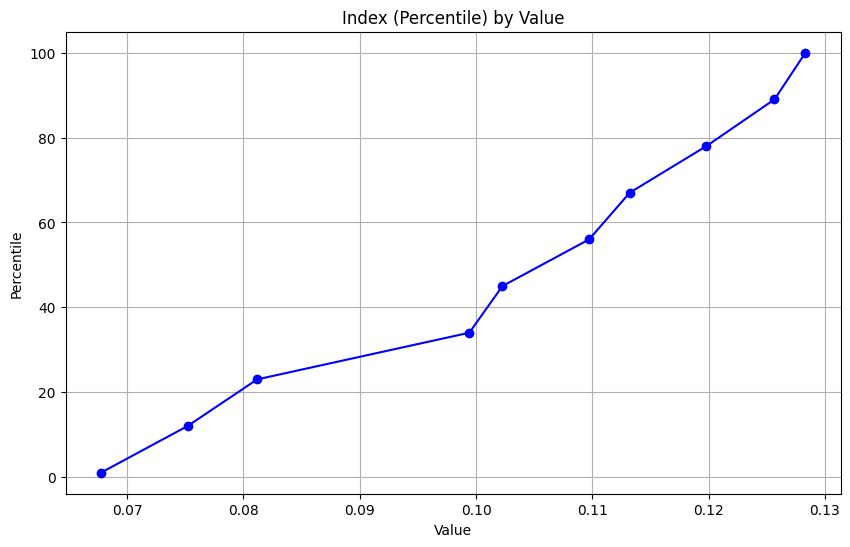

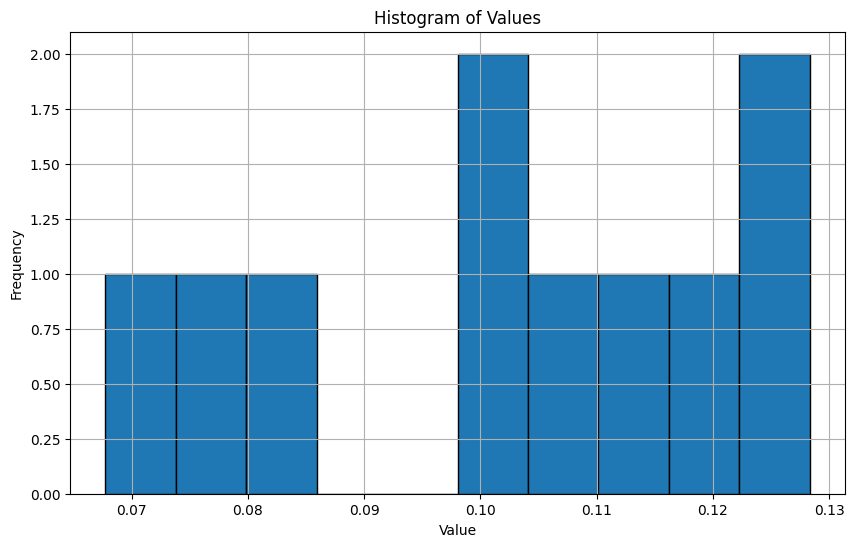

In [61]:
array = norm_dist_array[0]
# Generating y values as indices (percentiles in this context)
y_values = np.linspace(1, 100, len(array))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(array, y_values, marker='o', linestyle='-', color='b')
plt.title('Index (Percentile) by Value')
plt.xlabel('Value')
plt.ylabel('Percentile')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(array, bins=len(array), edgecolor='black')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [66]:
keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48]

numeric_cols = pred_data.iloc[:,keep_cols]

scaler = MinMaxScaler()

scaler.fit(numeric_cols)

scaled_numeric_cols = scaler.transform(numeric_cols)

scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

# scaled_numeric_df['dist_array'] = dist_array

scaled_numeric_df['norm_dist_array'] = norm_dist_array

id_fields = pred_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


In [67]:
numeric_df.columns

Index(['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top',
       'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude', 'water',
       'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
       'built', 'bare', 'snow_and_ice', 'elevation', 'landform', 'SRTM_mTPI',
       'aet', 'pdsi', 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn',
       'tmmx', 'vap', 'vpd', 'vs', 'agbd_m', 'norm_dist_array'],
      dtype='object')

In [162]:
# Model Definition
def build_model(input_shape,output_shape):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(512, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(output_shape, activation='linear')  # Adjust output layer according to your needs
    ])
    return model


In [106]:
scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()

In [129]:
scaled_numeric_df.dropna(inplace=True)

In [188]:
norm_dist_array = np.array([i for i in scaled_numeric_df['norm_dist_array']])

In [189]:

X = scaled_numeric_df.iloc[:, :-1]
y = scaled_numeric_df.iloc[:, -1]

x = np.array(X)
y = np.array(norm_dist_array)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [190]:
# print(X_train.shape[1])
model = build_model(X_train.shape[1],output_shape=10)

In [154]:
y_train.shape

(594, 1, 10)

In [191]:


# model = build_model((X_train.shape[1]))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics = ['mae'])
# model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

test_loss = model.evaluate(X_test, y_test)

# Predictions and Evaluation
predictions = model.predict(X_test)
# dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
# dummy_array[:, -1] = predictions
# inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
# dummy_array[:, -1] = y_test
# inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
# r_squared = r2_score(inversed_truth, inversed_predictions)

# return model, test_loss, r_squared, inversed_predictions, scaler

Epoch 1/600
4/4 [==============================] - 2s 99ms/step - loss: 2.1078 - mae: 1.0639 - val_loss: 0.0742 - val_mae: 0.2196
Epoch 2/600
4/4 [==============================] - 0s 23ms/step - loss: 1.8726 - mae: 1.0016 - val_loss: 0.0759 - val_mae: 0.2243
Epoch 3/600
4/4 [==============================] - 0s 24ms/step - loss: 1.7493 - mae: 0.9651 - val_loss: 0.0760 - val_mae: 0.2254
Epoch 4/600
4/4 [==============================] - 0s 22ms/step - loss: 1.7024 - mae: 0.9590 - val_loss: 0.0754 - val_mae: 0.2248
Epoch 5/600
4/4 [==============================] - 0s 24ms/step - loss: 1.5305 - mae: 0.9052 - val_loss: 0.0750 - val_mae: 0.2241
Epoch 6/600
4/4 [==============================] - 0s 23ms/step - loss: 1.6743 - mae: 0.9374 - val_loss: 0.0750 - val_mae: 0.2242
Epoch 7/600
4/4 [==============================] - 0s 27ms/step - loss: 1.6385 - mae: 0.9380 - val_loss: 0.0752 - val_mae: 0.2249
Epoch 8/600
4/4 [==============================] - 0s 25ms/step - loss: 1.5483 - mae: 0.91

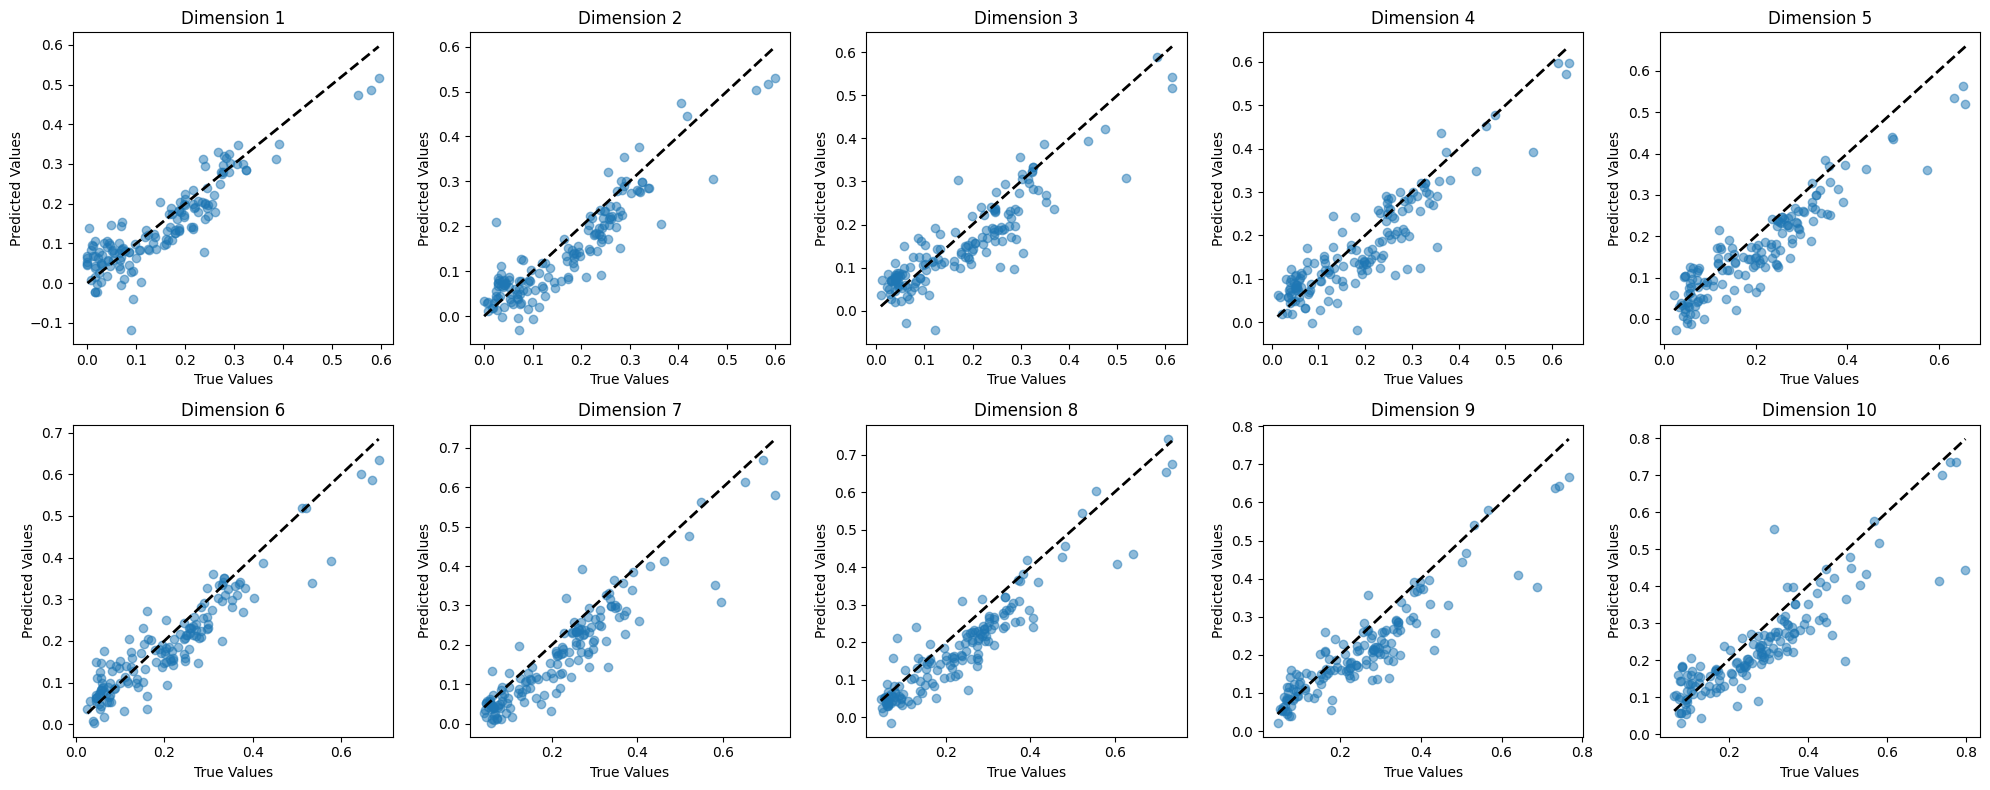

In [196]:
# Example data
n_samples = y_test.shape[1]
n_outputs = y_test.shape[0]  # This should be 10 based on your output shape

# Assuming y_true and y_pred are already defined and properly shaped
n_dimensions = y_test.shape[1]  # Should be 10

# Create a figure and axes with 10 subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i in range(n_dimensions):
    ax = axes[i // 5, i % 5]  # Determine the position of the subplot
    ax.scatter(y_test[:, i], predictions[:, i], alpha=0.5)
    ax.plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()], 'k--', lw=2)  # Line y=x
    ax.set_title(f'Dimension {i+1}')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [192]:
i = 4
for i in range(5):
  print(predictions[i])
  print(y_test[i])

[0.14653943 0.02701051 0.03374659 0.03166218 0.11877403 0.07061851
 0.09250121 0.03338052 0.14833108 0.10549088]
[0.04791966 0.0584589  0.06358563 0.07044505 0.07353381 0.07792603
 0.08452398 0.09551179 0.12721758 0.13077319]
[0.08032231 0.10210611 0.09380494 0.09547164 0.09315549 0.03182954
 0.19681643 0.13243838 0.08683875 0.13082752]
[0.07744235 0.09665226 0.10269868 0.10653016 0.10671727 0.1086789
 0.12306329 0.13156245 0.13632592 0.1504021 ]
[0.22196974 0.20585883 0.23654297 0.3266252  0.28314376 0.30295023
 0.26075938 0.3598713  0.33370855 0.45047   ]
[0.25984222 0.3643467  0.36825377 0.38189269 0.39171496 0.4018611
 0.40305968 0.41882887 0.42326714 0.50860379]
[0.20036788 0.23682627 0.18890733 0.24831131 0.24033165 0.2300862
 0.23161252 0.20565963 0.21423894 0.18984152]
[0.21607033 0.23962564 0.24444467 0.24639099 0.24657966 0.25543522
 0.25724198 0.27493272 0.28222982 0.28240353]
[0.01908429 0.07361282 0.05288262 0.07477806 0.03248937 0.08970249
 0.03883849 0.05731124 0.1057175